# Predicting EPL Result Using Poisson Distribution
Poisson Distribution Wiki: [Link](https://en.wikipedia.org/wiki/Poisson_distribution)

### Notebook Contents:

<a href='#O'>Objective</a> <br>
<a href='#DS'>Data Prep/Summary</a> <br>
<a href='#E'>Exploratory Data Analysis</a> <br>
<a href='#P'>Poisson Distribution</a> <br>
<a href='#M'>Modeling</a>

### Objective:

Predict the probability of each matches results of English Premier League using past season data using Poisson distribution.<br>
We are not doing any statistical modeling here. We simply predict the probability of how many goals home/away team would score in every single game in season.<br>

### Data Prep/Summary:
* English Premier League Stats (2012 - Present)
* English Premier League Fixtures (2012 - Present)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Poisson distribution
from scipy.stats import poisson

In [40]:
# Read past seasons data which have been cleaned beforehands
# We want teamnames, total number of goals each team scored and allowed ('Team', 'HGF', 'HGA')
# We calculate each teams offensive and defensive rating ('H_Att', 'A_Att', 'H_Def', 'A_Def')
# Number of yellow cards, red cards, and Discipline points and the number of clean sheets each team for the last season

# IMPORTANT
# table_13 has the final result of 13/14 season, with 12/13 seasons summary
# We will be able to predict the result using features 

table_13 = pd.read_csv('./Data/epl_table_1314.csv')[['Team', 'HGF', 'HGA', 'H_Att', 'A_Att', 'H_Def', 'A_Def', 'YC', 'RC', 'DIS', 'CS']]
table_14 = pd.read_csv('./Data/epl_table_1415.csv')[['Team', 'HGF', 'HGA', 'H_Att', 'A_Att', 'H_Def', 'A_Def', 'YC', 'RC', 'DIS', 'CS']]
table_15 = pd.read_csv('./Data/epl_table_1516.csv')[['Team', 'HGF', 'HGA', 'H_Att', 'A_Att', 'H_Def', 'A_Def', 'YC', 'RC', 'DIS', 'CS']]
table_16 = pd.read_csv('./Data/epl_table_1617.csv')[['Team', 'HGF', 'HGA', 'H_Att', 'A_Att', 'H_Def', 'A_Def', 'YC', 'RC', 'DIS', 'CS']]
table_17 = pd.read_csv('./Data/epl_table_1718.csv')[['Team', 'HGF', 'HGA', 'H_Att', 'A_Att', 'H_Def', 'A_Def', 'YC', 'RC', 'DIS', 'CS']]

table = [table_13, table_14, table_15, table_16, table_17]

In [41]:
# Read all season fixtures from 13/14 to 18/19 (present)
# We need home/away team and the final result to compare with our prediction
# We want how many goals they score to make useful EDAs

epl_detail_1314 = pd.read_csv('./Data/epl14.csv')[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]
epl_detail_1415 = pd.read_csv('./Data/epl15.csv')[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]
epl_detail_1516 = pd.read_csv('./Data/epl16.csv')[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]
epl_detail_1617 = pd.read_csv('./Data/epl17.csv')[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]
epl_detail_1718 = pd.read_csv('./Data/epl18.csv')[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]
epl_detail_1819 = pd.read_csv('./Data/epl19.csv')[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]

fixture = [epl_detail_1415, epl_detail_1516, epl_detail_1617, epl_detail_1718, epl_detail_1819]

### EDA
Number of Goals Scored per Match

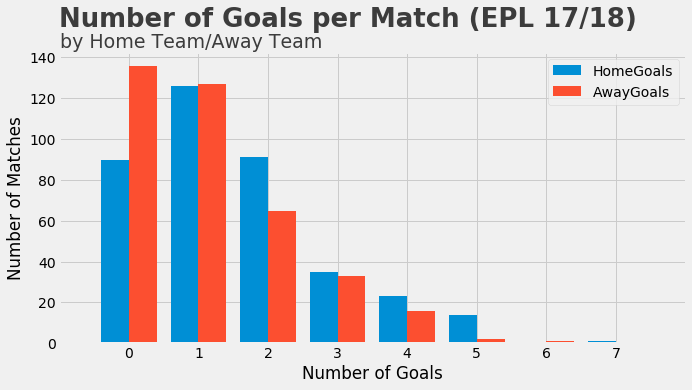

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
x = epl_detail_1718['FTHG'] 
y = epl_detail_1718['FTAG']
bins = np.linspace(0, 8, 9)
plt.hist([x, y], bins, label=['HomeGoals', 'AwayGoals'], align='left')
plt.legend(loc='upper right')
plt.text(-1, 155, "Number of Goals per Match (EPL 17/18)", fontsize=26, weight='bold', alpha=.75)
plt.text(-.99, 145 , "by Home Team/Away Team", fontsize=19, alpha=.75)
plt.ylabel("Number of Matches")
plt.xlabel("Number of Goals")
plt.xlim(left=-1, right = 8)
plt.xticks(bins[:-1]);

### Poisson Distribution

In [68]:
def result_percentage(dataframe, hometeam, awayteam):
    '''
    returns array of size 2.
    list of percentage of hometeam win/away win/draw
    dataframe of percentage of how many goals each team scores in 90 minutes (min: 0, max: 5)
    '''
    home_avg = dataframe['HGF'].sum()/380
    away_avg = dataframe['HGA'].sum()/380
    
    home_score = float(dataframe[dataframe['Team'] == hometeam]['H_Att']) * float(dataframe[dataframe['Team'] == awayteam]['A_Def']) * home_avg
    away_score = float(dataframe[dataframe['Team'] == awayteam]['A_Att']) * float(dataframe[dataframe['Team'] == hometeam]['H_Def']) * away_avg

    score = []
    # maximum score for a team is 5
    for goals in range(0, 6):
        scores = {}
        scores['Home'] = (poisson.pmf(goals, home_score)) # Hometeam score
        scores['Away'] = (poisson.pmf(goals, away_score)) # away score

        if len(scores) == 2:
                    score.append(scores)

    score = pd.DataFrame(score, columns=(['Home', 'Away']))

    # % of home team winning
    # home score > away score
    # home[1] * away[0]
    # home[2] * away[0] + home[2] * away[1]
    # home[3] * away[0] + home[3] * away[1] + home[3] * away[2]
    # home[4] * away[0] + home[4] * away[1] + home[4] * away[2] + home[4] * away[3]
    # home[5] * away[0] + home[5] * away[1] + home[5] * away[2] + home[5] * away[3]+  home[5] * away[4]
    home_w = 0
    away_w = 0
    draw = 0
    result = []
    for home in range(1, len(score)):
        for away in range(0, home):
            home_w += (score['Home'][home] * score['Away'][away])
    result.append(home_w)

    for away in range(1, len(score)):
        for home in range(0, away):
            away_w += (score['Home'][home] * score['Away'][away])
    result.append(away_w)

    for home in range(0, len(score)):
        away = home
        draw += (score['Home'][home] * score['Away'][away])
    result.append(draw)

    return result, score

In [116]:
mat = result_percentage(table_17, 'Arsenal', 'Chelsea')[1]
mat

,Home,Away
0,0.116639,0.213280
1,0.250619,0.329550
2,0.269249,0.254601
3,0.192842,0.131132
4,0.103589,0.050655
5,0.044516,0.015654


In [119]:
result = []
for i in mat['Home']:
    for j in mat['Away']:
        result.append(round(i * j, 4))
result = np.reshape(result, (6,6))
df_ = pd.DataFrame(result, index=range(0,6), columns=('0', '1', '2', '3', '4', '5'))
df_.index.names = ['Home']
df_.columns.names = ['Away']
df_

Away,0,1,2,3,4,5
Home,,,,,,
0,0.0249,0.0384,0.0297,0.0153,0.0059,0.0018
1,0.0535,0.0826,0.0638,0.0329,0.0127,0.0039
2,0.0574,0.0887,0.0686,0.0353,0.0136,0.0042
3,0.0411,0.0636,0.0491,0.0253,0.0098,0.0030
4,0.0221,0.0341,0.0264,0.0136,0.0052,0.0016
5,0.0095,0.0147,0.0113,0.0058,0.0023,0.0007


In [70]:
temp = pd.DataFrame(result_percentage(table_17, 'Arsenal', 'Chelsea')[0], index=('Home Win', 'Away Win', 'Draw')).T
temp.rename(index={0: "Probability"})

,Home Win,Away Win,Draw
Probability,0.493166,0.272024,0.207251


In [71]:
def decision(result_p):
    if result_p[2] > result_p[1] and result_p[2] > result_p[0]:
        return 'D'
    elif result_p[0] > result_p[1] and result_p[0] > result_p[2]:
        return 'H'
    elif result_p[1] > result_p[0] and result_p[1] > result_p[2]:
        return 'A'


In [72]:
def predict(fixture, rating):

    for i in range(len(fixture)):
        if fixture['HomeTeam'][i] in list(rating['Team']) and fixture['AwayTeam'][i] in list(rating['Team']):
            result = result_percentage(rating, fixture['HomeTeam'][i], fixture['AwayTeam'][i])[0]
            fixture.loc[i, 'Predict'] = decision(result)
            fixture.loc[i, 'W'] = result[0]
            fixture.loc[i, 'D'] = result[2]
            fixture.loc[i, 'L'] = result[1]

    fixture.loc[:, 'Result'] = (fixture.loc[:, 'FTR'] == fixture.loc[:, 'Predict']) * 1

In [73]:
for i in range(len(fixture)):
    predict(fixture[i], table[i])

In [74]:
epl_detail_1819.dropna().head()

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,Predict,W,D,L,Result
0,Manchester Utd,Leicester City,H,2,1,H,0.738472,0.138564,0.072993,1
3,Huddersfield,Chelsea,A,0,3,A,0.113782,0.204240,0.667711,1
4,Newcastle Utd,Tottenham,A,1,2,A,0.203776,0.275398,0.517535,1
7,Arsenal,Manchester City,A,0,2,A,0.215050,0.203304,0.556066,1
8,Liverpool,West Ham Utd,H,4,0,H,0.758934,0.077210,0.032043,1


In [75]:
epl_detail_1819.dropna()['Result'].mean()

0.6046511627906976

In [76]:
print(epl_detail_1415.dropna()['Result'].mean())
print(epl_detail_1516.dropna()['Result'].mean())
print(epl_detail_1617.dropna()['Result'].mean())
print(epl_detail_1718.dropna()['Result'].mean())
print(epl_detail_1819.dropna()['Result'].mean())

(epl_detail_1819.dropna()['Result'].mean() + epl_detail_1415.dropna()['Result'].mean() + 
 epl_detail_1516.dropna()['Result'].mean() + epl_detail_1617.dropna()['Result'].mean() + (epl_detail_1718.dropna()['Result'].mean())) / 5


0.5
0.4375
0.5257352941176471
0.5110294117647058
0.6046511627906976


0.51578317373461